# Single Cell apoptosis

As decribed in [Monier et al. 2015](http://www.nature.com/nature/journal/v518/n7538/full/nature14152.html).

We start with a simple hexagonal apical mesh with cylindrical symmetry. 

#### Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue import Sheet
from tyssue import config

from tyssue import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel

from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.io.hdf5 import load_datasets

### Loading the datasets and specifications

Here it is a cylindrical hexagonal mesh.

In [2]:
# Read pre-recorded datasets
h5store = '../examples/small_hexagonal.hf5'
from tyssue.io.hdf5 import save_datasets, load_datasets

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
# Corresponding specifications
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

# Model
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs)

sheet.get_opposite()
live_edges = sheet.edge_df[sheet.edge_df['opposite']==-1].index
dead_src = sheet.edge_df.loc[live_edges, 'srce'].unique()

### Boundary conditions
sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

### First energy minimization

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:

min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


### Custom display function

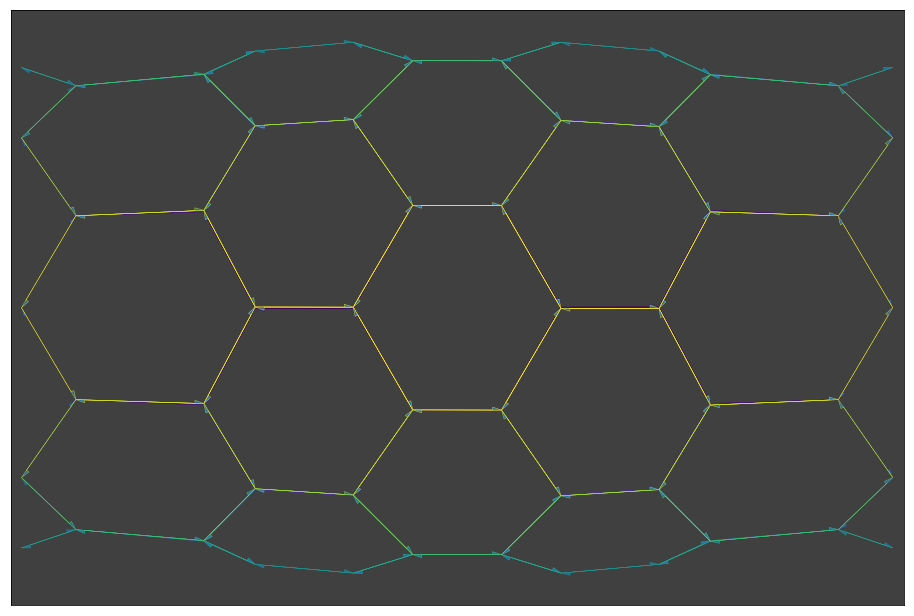

In [5]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-10, 10)
    ax.set_facecolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((16, 19))
    return fig, ax

fig, ax = leg_joint_view(sheet)


### Choosing an apoptotic cell 

In [6]:
apoptotic_cell = 16
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x   -7.673377
y    3.197728
z   -5.092089
Name: 16, dtype: float64
Indices of the apoptotic vertices: [40 51 41 50 52 53]


Cell behaviours, such as division or apoptosis, are defined as a series of unit changes in the tissue, such as the cell growth, or the abscission of the cell face once division is complete. For a given behavior, the next step often depends on the current state. This is managed by an EventManager object, which runs the behaviour.





In [7]:
from tyssue.behaviors.sheet_events import apoptosis
from tyssue.behaviors import EventManager


manager = EventManager('face')


sheet.settings['apoptosis'] = {
    'shrink_rate': 0.5,
    'critical_area': 8.,
    'radial_tension': 0.2,
    'contractile_increase': 0.3,
    'contract_span': 2
    }

sheet.face_df['id'] = sheet.face_df.index.values
manager.append(apoptosis, apoptotic_cell,
               kwargs=sheet.settings['apoptosis'])


In [8]:
manager.next

deque([(<function tyssue.behaviors.sheet_events.apoptosis>,
        16,
        (),
        {'contract_span': 2,
         'contractile_increase': 0.3,
         'critical_area': 8.0,
         'radial_tension': 0.2,
         'shrink_rate': 0.5})])

We perform the events at each time points to run the simulation

In [9]:
t = 0
stop=100
while manager.current and t < stop:
    manager.execute(sheet)
    t += 1
    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('single_apopto_{:03d}.png'.format(t))
    plt.close(fig)
    manager.update()

/home/guillaume/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


### 3D view with ipyvolume

In [10]:
from tyssue.draw.ipv_draw import view_ipv

In [11]:
color = sheet.vert_df['y']
fig, mesh = view_ipv(sheet, coords=['z', 'x', 'y'], color=color)
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.124395, 0.578002, 0.548287],
       [0.232815, 0.732247, 0.459277],
       [0.545524, 0.838039, 0.275626],
       [0.187231, 0.414746, 0.556547],
       [0.192357, 0.403199, 0.555836],
       [0.129933, 0.559582, 0.551864],
       [0.239374, 0.735588, 0.455688],
       [0.129933, 0.559582, 0.551864],
       [0.232815, 0.732247, 0.459277],
       [0.575563, 0.844566, 0.256415],
       [0.555484, 0.840254, 0.269281],
       [0.201239, 0.38367 , 0.554294],
       [0.201239, 0.38367 , 0.554294],
       [0.128729, 0.563265, 0.551229],
       [0.232815, 0.732247, 0.459277],
       [0.127568, 0.566949, 0.550556],
       [0.239374, 0.735588, 0.455688],
       [0.555484, 0.840254, 0.269281],
       [0.585678, 0.846661, 0.249897],
       [0.190631, 0.407061, 0.556089],
       [0.187231, 0.414746, 0.556547],
       [0.124395, 0.578002, 0.548287],
       [0.232815, 0.732247, 0.459277],
       [0.545524, 0.838039, 0.275626],
       [0.79376 , 0.880678, 0.120005],
       [0.886271, 0.892374, 0.095374],
       [0.876168, 0.891125, 0.09525 ],
       [0.89632 , 0.893616, 0.096335],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.866013, 0.889868, 0.095953],
       [0.804182, 0.882046, 0.114965],
       [0.886271, 0.892374, 0.095374],
       [0.906311, 0.894855, 0.098125],
       [0.79376 , 0.880678, 0.120005],
       [0.886271, 0.892374, 0.095374],
       [0.79376 , 0.880678, 0.120005],
       [0.545524, 0.838039, 0.275626],
       [0.866013, 0.889868, 0.095953],
       [0.741388, 0.873449, 0.149561],
       [0.535621, 0.835785, 0.281908],
       [0.688944, 0.865448, 0.182725],
       [0.772852, 0.877868, 0.131109],
       [0.477504, 0.821444, 0.318195],
       [0.412913, 0.803041, 0.357269],
       [0.79376 , 0.880678, 0.120005],
       [0.545524, 0.838039, 0.275626],
       [0.232815, 0.732247, 0.459277],
       [0.124395, 0.578002, 0.548287],
       [0.226397, 0.728888, 0.462789],
       [0.124395, 0.578002, 0.548287],
       [0.146616, 0.67305 , 0.508936],
       [0.202219, 0.715272, 0.476084],
       [0.143343, 0.522773, 0.556295],
       [0.151918, 0.500685, 0.557587],
       [0.232815, 0.732247, 0.459277],
       [0.124395, 0.578002, 0.548287],
       [0.187231, 0.414746, 0.556547],
       [0.255645, 0.260703, 0.528312],
       [0.188923, 0.41091 , 0.556326],
       [0.237441, 0.305202, 0.541921],
       [0.278826, 0.17549 , 0.483397],
       [0.269308, 0.218818, 0.509577],
       [0.246811, 0.283237, 0.535941],
       [0.201239, 0.38367 , 0.554294],
       [0.279574, 0.170599, 0.479997],
       [0.282623, 0.140926, 0.457517],
       [0.187231, 0.414746, 0.556547],
       [0.255645, 0.260703, 0.528312],
       [0.28229 , 0.145912, 0.46151 ],
       [0.282656, 0.100196, 0.42216 ],
       [0.283197, 0.11568 , 0.436115],
       [0.272594, 0.025563, 0.353093],
       [0.26851 , 0.009605, 0.335427],
       [0.277018, 0.050344, 0.375715],
       [0.269944, 0.014625, 0.341379],
       [0.282327, 0.094955, 0.417331],
       [0.274952, 0.037752, 0.364543],
       [0.267004, 0.004874, 0.329415],
       [0.28229 , 0.145912, 0.46151 ],
       [0.282656, 0.100196, 0.42216 ],
       [0.28229 , 0.145912, 0.46151 ],
       [0.255645, 0.260703, 0.528312],
       [0.283197, 0.11568 , 0.436115],
       [0.279566, 0.067836, 0.391917],
       [0.271828, 0.209303, 0.504434],
       [0.26658 , 0.228262, 0.514349],
       [0.279566, 0.067836, 0.391917],
       [0.283091, 0.110553, 0.431554],
       [0.263663, 0.237631, 0.518762],
       [0.270595, 0.214069, 0.507052],
       [0.28229 , 0.145912, 0.46151 ],
       [0.255645, 0.260703, 0.528312],
       [0.119512, 0.607464, 0.540218]]), lines=array([[ 0,  1],
       [ 3,  0],
       [ 1,  6],
       [ 4,

Provided you have ImageMagick installed, we can convert the output to a nice gif, like so:

In [12]:
%%bash
convert single_apopto*.png single_apopto.gif
rm single_apopto*.png

![Gif of the resulting simulation](single_apopto.gif)